In [78]:
import torch
import sklearn
from torcheval.metrics import R2Score

torch.manual_seed(42)

In [79]:
def f(x):
  return (1+x)**(1/2)

a) Computing random labels

In [80]:
N=10000
xs=torch.rand(N)
labels=f(xs)

print(xs,"\n",labels)

tensor([0.8823, 0.9150, 0.3829,  ..., 0.2181, 0.9120, 0.4111]) 
 tensor([1.3720, 1.3838, 1.1760,  ..., 1.1037, 1.3827, 1.1879])


b) Closed form solution

In [81]:
X=torch.concat((torch.ones(N).unsqueeze(1),xs.unsqueeze(1)), dim=1)
print("X matrix", X)

w=(X.t()@X).inverse()@X.t()@labels
print("Weights", w)
print("labels comparison", X@w, labels)

X matrix tensor([[1.0000, 0.8823],
        [1.0000, 0.9150],
        [1.0000, 0.3829],
        ...,
        [1.0000, 0.2181],
        [1.0000, 0.9120],
        [1.0000, 0.4111]])
Weights tensor([1.0131, 0.4116])
labels comparison tensor([1.3763, 1.3898, 1.1707,  ..., 1.1029, 1.3885, 1.1824]) tensor([1.3720, 1.3838, 1.1760,  ..., 1.1037, 1.3827, 1.1879])


c) sklearn linear regression

In [82]:
lin_reg =sklearn.linear_model.LinearRegression()
lin_reg.fit(xs.unsqueeze(1), labels)
y_pred=lin_reg.predict(xs.unsqueeze(1))

print("Weights", lin_reg.coef_)
print("labels comparison", y_pred, labels)
print(sklearn.metrics.r2_score(labels,y_pred))

Weights [0.41161126]
labels comparison [1.3762994 1.3897734 1.1707385 ... 1.1029171 1.3885245 1.1823584] tensor([1.3720, 1.3838, 1.1760,  ..., 1.1037, 1.3827, 1.1879])
0.9980678558349609


d) Grad descent from scratch

In [83]:
xs.requires_grad=True
X.requires_grad=True
def gradient(x, y):
  loss=(y**2-x**2).mean()
  loss.backward()
  return loss.item()

In [86]:
torch.manual_seed(42)

def gradient_descent():
    weights = torch.randn(2, requires_grad=True)
    lr = 0.1
    metric = R2Score()

    for i in range(200):
        y_pred = X @ weights
        loss = torch.mean((y_pred - labels) ** 2)

        loss.backward()

        with torch.no_grad():
            weights -= lr * weights.grad
            weights.grad.zero_()

        if i % 10 == 0:
            metric.reset()
            metric.update(y_pred.squeeze(), labels)
            print("iteration", i, "R^2:", metric.compute().item())
    return weights

weights = gradient_descent()


iteration 0 R^2: -46.76605987548828
iteration 10 R^2: 0.8432192206382751
iteration 20 R^2: 0.9841574430465698
iteration 30 R^2: 0.9876934885978699
iteration 40 R^2: 0.9901065826416016
iteration 50 R^2: 0.9919576644897461
iteration 60 R^2: 0.9933784008026123
iteration 70 R^2: 0.9944687485694885
iteration 80 R^2: 0.995305597782135
iteration 90 R^2: 0.9959478378295898
iteration 100 R^2: 0.9964407682418823
iteration 110 R^2: 0.9968190789222717
iteration 120 R^2: 0.9971094131469727
iteration 130 R^2: 0.9973322749137878
iteration 140 R^2: 0.9975032806396484
iteration 150 R^2: 0.9976345300674438
iteration 160 R^2: 0.997735321521759
iteration 170 R^2: 0.9978126287460327
iteration 180 R^2: 0.9978719353675842
iteration 190 R^2: 0.9979174733161926


e) linear regression using pytorch

In [85]:
class LinearRegression(torch.nn.Module):
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.linear = torch.nn.Linear(input_dim, output_dim)

  def forward(self, x):
    return self.linear(x)

In [153]:
torch.manual_seed(42)
linreg = LinearRegression(2,1)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(linreg.parameters(), lr=0.01)

metric = R2Score()

for epoch in range(1000):
  y_pred = linreg(X)
  loss = criterion(y_pred, labels.unsqueeze(1))

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  if epoch % 100 == 0:
    metric.reset()
    metric.update(y_pred, labels.unsqueeze(1))
    print(f"Epoch {epoch} R^2:", metric.compute().item())

Epoch 0 R^2: -20.59257698059082
Epoch 100 R^2: 0.7062540054321289
Epoch 200 R^2: 0.9728284478187561
Epoch 300 R^2: 0.997237503528595
Epoch 400 R^2: 0.99805748462677
Epoch 500 R^2: 0.9980677962303162
Epoch 600 R^2: 0.9980677962303162
Epoch 700 R^2: 0.9980677962303162
Epoch 800 R^2: 0.9980677962303162
Epoch 900 R^2: 0.9980677962303162


f) Mini batch from scratch

In [155]:
torch.manual_seed(42)
linreg2 = LinearRegression(2,1)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(linreg2.parameters(), lr=0.01)

metric = R2Score()

indices = torch.randperm(N)
X_batches = torch.split(X[indices], 32)
labels_batches = torch.split(labels[indices], 32)

# I have no idea why it returns an error for loss.backward without retaining the graph. I couldn't resolve the problem.

for epoch in range(10):
  for x, y in zip(X_batches, labels_batches):
    y_pred = linreg2(x)
    loss = criterion(y_pred, y.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()

  metric.reset()
  metric.update(y_pred, y.unsqueeze(1))
  print(f"Epoch {epoch} R^2:", metric.compute().item())

Epoch 0 R^2: 0.9964289665222168
Epoch 1 R^2: 0.9980739951133728
Epoch 2 R^2: 0.9980676770210266
Epoch 3 R^2: 0.9980713129043579
Epoch 4 R^2: 0.9980702996253967
Epoch 5 R^2: 0.9980353116989136
Epoch 6 R^2: 0.9980272650718689
Epoch 7 R^2: 0.9980682730674744
Epoch 8 R^2: 0.9980848431587219
Epoch 9 R^2: 0.9980302453041077


closed form tensor([1.0131, 0.4116])
sklearn tensor([1.0108, 0.4160], requires_grad=True)
scratch Parameter containing:
tensor([[0.8597, 0.4116]], requires_grad=True)
scratch mini batch Parameter containing:
tensor([[0.8598, 0.4117]], requires_grad=True)


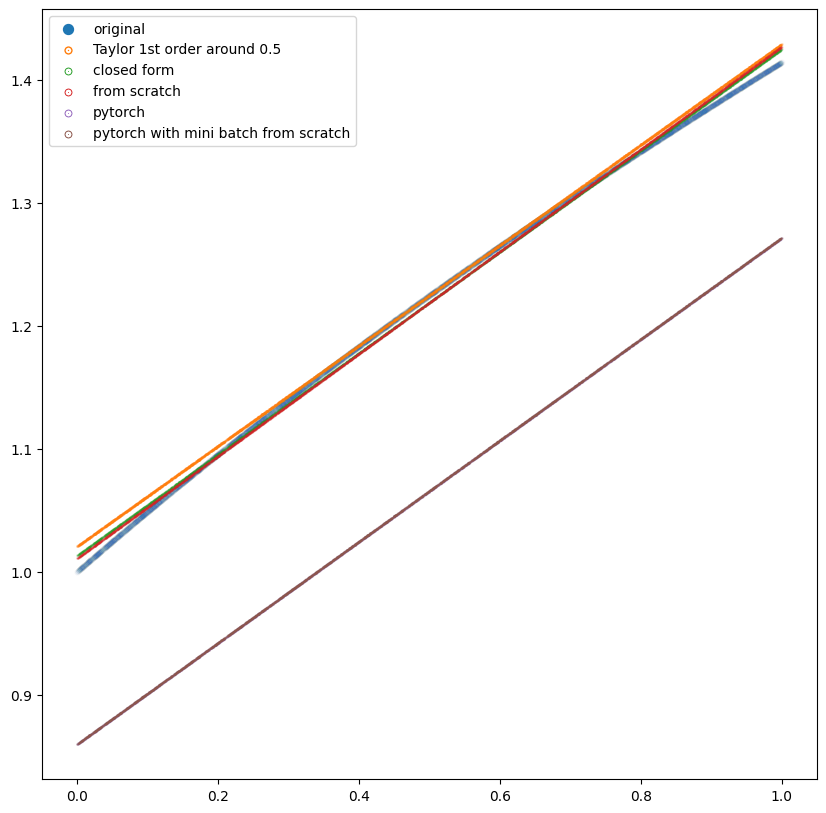

In [185]:
print("closed form", w)
print("sklearn", weights)
print("scratch", linreg.linear.weight)
print("scratch mini batch", linreg2.linear.weight)

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
xs_np=xs.detach().numpy()
ax.scatter(xs_np , labels.detach().numpy(), alpha=0.01, s=10)
ax.scatter(xs_np , np.sqrt(1+0.5)+(1/(2*np.sqrt(1+0.5)))*(xs_np-0.5), alpha=0.1, s=1)
ax.scatter(xs_np , (X@w).detach().numpy() , alpha=0.1, s=0.5)
ax.scatter(xs_np , (X@weights).detach().numpy() , alpha=0.1, s=0.5)
ax.scatter(xs_np , (X@linreg.linear.weight.t()).detach().numpy() , alpha=0.1, s=0.5)
ax.scatter(xs_np , (X@linreg2.linear.weight.t()).detach().numpy(), alpha=0.1 , s=0.5)
leg = ax.legend(["original", "Taylor 1st order around 0.5", "closed form", "from scratch", "pytorch", "pytorch with mini batch from scratch"])

for lh in leg.legend_handles:
    lh.set_alpha(1)
    lh.set_linewidth(5)
plt.show()

In [187]:
def mse(x,y):
  return ((x-y)**2).mean()

def taylor(x,a):
  return np.sqrt(1+a)+1/(2*np.sqrt(1+a))*(x-a)

# compare with taylor
print("original", mse(taylor(xs_np, 0.5) , labels.detach().numpy()))
print("closed form", mse(taylor(xs_np, 0.5) , (X@w).detach().numpy()))
print("from scratch", mse(taylor(xs_np, 0.5) , (X@weights).detach().numpy()))
print("pytorch", mse(taylor(xs_np, 0.5) , (X@linreg.linear.weight.t()).detach().numpy()))
print("from scratch mini batch", mse(taylor(xs_np, 0.5) , (X@linreg2.linear.weight.t()).detach().numpy()))


original 6.180084491972537e-05
closed form 3.445743865107967e-05
from scratch 4.034568084363287e-05
pytorch 0.05337136878656675
from scratch mini batch 0.05331617210500015
